In [1]:
import settings
import logging
import os
from time import time
log_file = os.path.join(settings.project_root, 'tmp', 'Project.log')
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logger = logging.getLogger('text_similar')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',  level=logging.DEBUG, filename=log_file)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import gensim
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [3]:
data_file = os.path.join(settings.project_root, 'tmp', 'data_file.csv')
logger.info('Loading data into dataFrame')
df = pd.DataFrame([line.split(',') for line in open(data_file)], columns=['genre', 'story'])
logger.info('Size of dataFrame = {}'.format(df.memory_usage().sum()/(1024*1024)))

In [4]:
test_size = 0.15
logger.info('Creating Train-text split with test_size = {}'.format(test_size))
train_data, test_data = train_test_split(df, test_size=test_size, random_state=42)

In [41]:
genres = df['genre'].unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    target_names = genres
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print((target.shape, predictions.shape))
    print('accuracy %s' % accuracy_score(target, predictions))
    print('f1_Score : {}'.format(f1_score(target, predictions), labels=genres, pos_label=None, average='weighted'))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    logger.info('plotting confusion matrix')
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

def predict(model, classifier, data, labels, f_name):
    tick = time()
    logger.info('transforming features')
    data_features = get_transformed(data, model, f_name)
    logger.info('feature transformation complete, time taken: {}'.format(round(time()-tick)))
    
    tick = time()
    logger.info('predicting labels')
    predictions = classifier.predict(data_features)
    logger.info('labels predicted, time taken: {}'.format(round(time()-tick)))

    tick = time()
    logger.info('evaluating predictions')
    target = labels
    evaluate_prediction(predictions, target)
    logger.info('evaluating complete in {}'.format(round(time()-tick)))
    

In [6]:
def train_classifier(features, labels, f_name=None):
    if os.path.isfile(f_name):
        logger.info('Loading logreg classifier from {}'.format(f_name))
        logreg = save_load(f_name, opt='load')
    else:
        logreg = linear_model.LogisticRegression(n_jobs=-1, C=1e5)
        tick = time()
        logger.info('training logistic regression model')
        logreg = logreg.fit(features, labels)
        logger.info('training complete, time taken: {}'.format(round(time()-tick)))
        logger.info('Saving logreg classifier at {}'.format(f_name))
        save_load(f_name, opt='save', material=logreg)
    return logreg

In [7]:
STOPWORDS = """
a about above across after afterwards again against all almost alone along already also although always am among amongst amoungst amount an and another any anyhow anyone anything anyway anywhere are around as at back be
became because become becomes becoming been before beforehand behind being below beside besides between beyond bill both bottom but by call can
cannot cant co computer con could couldnt cry de describe
detail did didn do does doesn doing don done down due during
each eg eight either eleven else elsewhere empty enough etc even ever every everyone everything everywhere except few fifteen
fify fill find fire first five for former formerly forty found four from front full further get give go
had hand has hasnt have he head hence her here hereafter hereby herein hereupon hers herself him himself his how however hundred i ie
if in inc indeed interest into is it its itself keep last latter latterly least less ltd
just
kg km
made make many may me meanwhile might mill mine more moreover most mostly move much must my myself name namely
neither never nevertheless next nine no nobody none noone nor not nothing now nowhere of off
often on once one only onto or other others otherwise our ours ourselves out over own part per
perhaps please put rather re
quite
rather really regarding
same say said see seem seemed seeming seems serious several she should show side since sincere six sixty so some somehow someone something sometime sometimes somewhere still such system take ten
than that the their them themselves then thence there thereafter thereby therefore therein thereupon these they thick thin third this those though three through throughout thru thus to together too top toward towards twelve twenty two un under
until up unless upon us used using
various very very via
was we well were what whatever when whence whenever where whereafter whereas whereby wherein whereupon wherever whether which while whither who whoever whole whom whose why will with within without would yet you
your yours yourself yourselves
"""
STOPWORDS = [word for word in STOPWORDS.split()]

In [8]:
def make_dictionary(docs, loc, stop_words, min_df=5, max_df=0.75, max_features=100000):
        if os.path.isfile(loc):
            logger.info('loading dictionary from {}'.format(loc))
            dictionary = gensim.corpora.Dictionary.load(loc)
        else:
            logger.info('creating vocabulary for documents')
            dictionary = gensim.corpora.Dictionary(documents = (gensim.parsing.preprocess_string(doc) for doc in docs))

            dictionary.filter_extremes(no_below=min_df,
                                       no_above=max_df,
                                       keep_n=max_features)

            stop_ids = [dictionary.token2id[token] for token in
                        dictionary.itervalues() if token in stop_words]
            remove_ids = [dictionary.token2id[token] for token in
                          dictionary.itervalues() if len(token) < 3]
            dictionary.filter_tokens(stop_ids + remove_ids)

            dictionary.compactify()
            logger.info('Saving dictionary at {}'.format(loc))
            dictionary.save(loc)
        return dictionary

In [9]:
tick = time()
tmp_dir = os.path.join(settings.project_root, 'tmp', 'novel')
dict_file = os.path.join(tmp_dir, 'project.dict')
dictionary = make_dictionary(docs=train_data['story'], loc=dict_file, stop_words=STOPWORDS)
logger.info('Created dictionary in {} s'.format(round(time()-tick)))

In [10]:
import cPickle as pickle
def save_load(path, opt, material=None):
    if opt=='save':
        logger.info('Dumping material in {}'.format(path))
        pickle.dump(material, open(path, 'wb'))
    elif opt=='load':
        material = pickle.load(open(path, 'rb'))
        return material
    else:
        raise NotImplementerError

In [20]:
def train_transformer(train_data, dictionary, stop_words, model, f_name=None):
    if os.path.isfile(f_name):
        tick = time()
        logger.info('loading trained model from {}'.format(f_name))
        model = save_load(f_name, opt='load')
    else:
        tick = time()
        logger.info('Creating model')
        model.fit(train_data)
        logger.info('Created model in : {}'.format(round(time()-tick),3))
        logger.info('Saving model at {}'.format(f_name))
        save_load(f_name, opt='save', material=model )
    return model

In [12]:
def get_transformed(data, model, f_name=None):
    if os.path.isfile(f_name):
        logger.info('Loading transformed data from {}'.format(f_name))
        features = save_load(f_name, opt='load')
    else:
        tick = time()
        logger.info('Transforming data')
        features = model.transform(data)
        logger.info('Transformation complete in : {}'.format(round(time()-tick),3))
        logger.info('Saving transformed data at {}'.format(f_name))
        save_load(f_name, opt='save', material=features)
    return features

In [13]:
count_vectorizer = CountVectorizer(analyzer="word", 
                                           tokenizer=gensim.parsing.preprocess_string,
                                           preprocessor=None,
                                           stop_words='english',
                                           vocabulary= {value:key for key, value in dictionary.iteritems()},
                                           max_features = 100000,
                                           max_df=0.75,
                                           min_df=5
                                           )

In [14]:
bow_model_file = os.path.join(tmp_dir, 'bow.model')
bow_model  = train_transformer(train_data=train_data['story'], dictionary=dictionary, stop_words=STOPWORDS, model=count_vectorizer, f_name=bow_model_file)

In [15]:
bow_train_file = os.path.join(tmp_dir,'train_bow.dat')
bow_features = get_transformed(data=train_data['story'], model=bow_model, f_name=bow_train_file)

In [16]:
bow_logreg_file = os.path.join(tmp_dir, 'bow_logreg.model')
bow_logreg = train_classifier(bow_features,train_data['genre'], f_name=bow_logreg_file)

accuracy 0.669333333333
f1_Score : 0.670045748041
confusion matrix
 [[2106  287  292  124  192]
 [ 320 1840  491  155  209]
 [ 352  503 1711  118  290]
 [ 160  209  147 2329  166]
 [ 219  308  273  145 2054]]
(row=expected, col=predicted)


C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


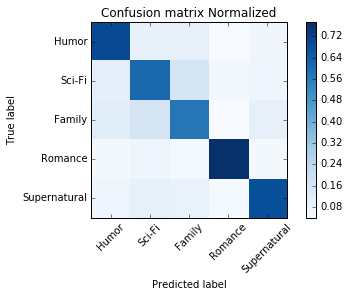

In [17]:
test_bow_file = os.path.join(tmp_dir, 'test_bow.dat')
predict(model=bow_model, classifier=bow_logreg, data=test_data['story'], labels=test_data['genre'], f_name=test_bow_file)

In [21]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word", 
                                           tokenizer=gensim.parsing.preprocess_string,
                                           preprocessor=None,
                                           stop_words='english',
                                           vocabulary= {value:key for key, value in dictionary.iteritems()},
                                           max_features = 100000,
                                           max_df=0.75,
                                           min_df=5,
                                           norm='l2',
                                           use_idf=True,
                                           smooth_idf=True,
                                           sublinear_tf=False)

In [22]:
tfidf_model_file = os.path.join(tmp_dir, 'tfidf_transformer.model')
tfidf_model = train_transformer(train_data=train_data['story'], dictionary=dictionary, stop_words=STOPWORDS, model=tfidf_vectorizer, f_name=tfidf_model_file)

In [23]:
tfidf_train_file = os.path.join(tmp_dir,'train_tfidf.dat')
tfidf_features = get_transformed(train_data['story'], tfidf_model, f_name=tfidf_train_file)

In [24]:
tfidf_logreg_file = os.path.join(tmp_dir, 'tfidf_logreg.model')
tfidf_logreg = train_classifier(tfidf_features, train_data['genre'], f_name=tfidf_logreg_file)

accuracy 0.653666666667
f1_Score : 0.653099891862
confusion matrix
 [[2006  327  327  149  192]
 [ 347 1701  536  188  243]
 [ 364  539 1599  163  309]
 [ 163  175  173 2356  144]
 [ 202  216  267  171 2143]]
(row=expected, col=predicted)


C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


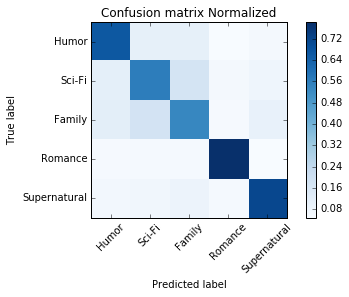

In [25]:
test_tfidf_file = os.path.join(tmp_dir, 'test_tfidf.dat')
predict(model=tfidf_model, classifier=tfidf_logreg, data=test_data['story'], labels=test_data['genre'], f_name=test_tfidf_file)

In [26]:
lda_model = LatentDirichletAllocation(n_topics=10,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      learning_method='online',
                                      learning_decay=0.7,
                                      learning_offset=10.0,
                                      max_iter=10,
                                      batch_size=128,
                                      evaluate_every=-1,
                                      total_samples=1000000.0,
                                      perp_tol=0.1,
                                      mean_change_tol=0.001,
                                      max_doc_update_iter=100,
                                      n_jobs=-1,
                                      verbose=0,
                                      random_state=42)

In [28]:
bow_lda_model_file = os.path.join(tmp_dir, 'bow_lda.model')
bow_lda_model = train_transformer(train_data=bow_features, dictionary=dictionary, stop_words=STOPWORDS, model=lda_model, f_name=bow_lda_model_file)

In [43]:
bow_lda_train_features_file = os.path.join(tmp_dir,'train_bow_lda.dat')
bow_lda_train_features = get_transformed(bow_features, bow_lda_model, f_name=bow_lda_train_features_file)
bow_test_features_file = os.path.join(tmp_dir,'test_bow.dat')
bow_test_features = save_load(bow_test_features_file, opt='load')
bow_lda_test_features_file = os.path.join(tmp_dir,'test_bow_lda.dat')

(15000, 72991)


In [48]:
bow_lda_logreg_file = os.path.join(tmp_dir, 'bow_lda_logreg.model')
bow_lda_logreg = train_classifier(bow_lda_train_features, train_data['genre'], f_name=bow_lda_logreg_file)

(85000L, 10L) (85000L,)


(15000, 72991) (15000L,)
((15000L,), (15000L,))
accuracy 0.4052
f1_Score : 0.403880908098


C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


confusion matrix
 [[1289  797  420  196  299]
 [ 680 1277  424  346  288]
 [ 739  812  787  131  505]
 [ 279  428  108 1745  451]
 [ 535  519  518  447  980]]
(row=expected, col=predicted)


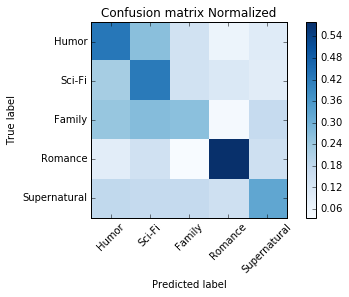

In [51]:
bow_lda_test_file = os.path.join(tmp_dir, 'test_bow_lda.dat')
predict(model=bow_lda_model, classifier=bow_lda_logreg, data=bow_test_features, labels=test_data['genre'], f_name=bow_lda_test_file)

In [53]:
tfidf_lda_model_file = os.path.join(tmp_dir, 'tfidf_lda.model')
tfidf_lda_model = train_transformer(train_data=tfidf_features, dictionary=dictionary, stop_words=STOPWORDS, model=lda_model, f_name=tfidf_lda_model_file)

In [56]:
tfidf_lda_train_features_file = os.path.join(tmp_dir,'train_tfidf_lda.dat')
tfidf_lda_train_features = get_transformed(tfidf_features, tfidf_lda_model, f_name=tfidf_lda_train_features_file)
tfidf_test_features_file = os.path.join(tmp_dir,'test_tfidf.dat')
tfidf_test_features = save_load(tfidf_test_features_file, opt='load')
tfidf_lda_test_features_file = os.path.join(tmp_dir,'test_tfidf_lda.dat')

In [57]:
tfidf_lda_logreg_file = os.path.join(tmp_dir, 'tfidf_lda_logreg.model')
tfidf_lda_logreg = train_classifier(tfidf_lda_train_features, train_data['genre'], f_name=tfidf_lda_logreg_file)

((15000L,), (15000L,))
accuracy 0.265333333333
f1_Score : 0.231916130932


C:\Users\param_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


confusion matrix
 [[1497  318   99  875  212]
 [1373  537   62  779  264]
 [1310  406  134  830  294]
 [1006  277   44 1395  289]
 [1063  325   83 1111  417]]
(row=expected, col=predicted)


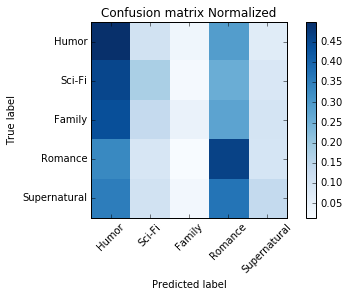

In [59]:
tfidf_lda_test_file = os.path.join(tmp_dir, 'test_tfidf_lda.dat')
predict(model=tfidf_lda_model, classifier=tfidf_lda_logreg, data=tfidf_test_features, labels=test_data['genre'], f_name=tfidf_lda_test_file)